# Variational autoencoder for real-valued data

This notebook contains the class definition of a VAE with detailed explanations about all steps.

In [6]:
% matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set a random seed for reproduction
np.random.seed(seed=0)
tf.set_random_seed(seed=0)

In [7]:
# Import the MNIST Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Xavier initialization

Xavier initialization is a technique for initalizing weights in a neural network. It ensures that the initial weight values of the network are neither too high nor too low, such that the signal propagated through the network remains within a reasonable range of values.
Xavier initalization is based on initializing the weights by drawing values from a distribution with zero mean and a specific variance, that depends on the number of incoming and outgoing connections as well as on the activation function used.
Details about the technique can be found in the paper ["Understanding the difficulty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

A post on how to perform Xavier initalization in TensorFlow can be found [here](https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow)

In [8]:
def xavier_init(fan_in, fan_out, constant=1):
    """
    Performs a Xavier initialization
    
    Args:
        fan_in: number of incoming connections
        fan_out: number of outgoing connections

    Returns:
         Tensor of shape (fan_in, fan_out) filled with random uniform values 
         in the range [minval, maxval).
    """
    low = -constant*np.sqrt(6.0/(fan_in+fan_out))
    high = constant*np.sqrt(6.0/(fan_in+fan_out))
    return tf.Variable(tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32))

# Specification of the variational autoencoder (VAE) model

This implementation follows the model introduced by Kingma and Welling. Details can be found in the corresponding [paper](https://arxiv.org/pdf/1312.6114.pdf). The paper is especially helpful for understanding the computations happening in the encoder and decoder network (see appendix C in the paper) as well as the two parts of the loss function and how they are computed (appendix B and C).

This implementation is based on an existing [implementation](https://jmetzen.github.io/2015-11-27/vae.html).

In [9]:
class VAE(object):
    
    def __init__(self, net_architecture, activation_fct=tf.nn.softplus, learning_rate=.001, batch_size=100):
        
        # Network parameters
        self.net_architecture = net_architecture
        self.activation_fct = activation_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # Network input
        self.x = tf.placeholder(tf.float32, shape=[None, net_architecture["n_input"]])
        
        # Create the network, inluding both the encoder and decoder
        self._create_net()
        
        # Create the 
        self._loss_optimizer()
        
        # Initialize all variables
        init = tf.global_variables_initializer()
        
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _create_net(self):
        """
        Creates the VAE network by initializing the weights and setting up the 
        encoder and decoder networks.
        
        """
        # Initialize all weights and biases of the VAE
        net_weights = self._init_weights(**self.net_architecture)

        # Use the encoder network to compute the mean and log(variance**2) of a Gaussian distribution 
        # (the encoder network is usually taken to be a Gaussian distribution)
        self.z_mean, self.z_log_sigma_sq = self._encoder_network(net_weights['weights_encoder'], net_weights['biases_encoder'])

        # As a next step, we want to sample values of z to be input into the
        # decoder network. For this, and to be able to perform backpropagation we employ 
        # the reparametrization trick:
        # Since our posterior is normally distributed, we can approximate it with another
        # with samples (called eps below) from another posterior. We can then
        # obtain samples of z by computing: z = mu + sigma*epsilon
        n_z = net_architecture["n_z"] #dimension of latent space
        eps = tf.random_normal((self.batch_size, n_z))
        
        # Sampled vector of latent variables z (z = mu + sigma*eps)
        # As our sigmas are log(sigmas**2) we have to apply the exponential function
        # to compute the "plain" variance
        self.z = tf.add(self.z_mean, 
                       tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)),eps))
        
        
        # Use the decoder network to reconstruct the input
        self.x_reconstr = self._decoder_network(net_weights["weights_decoder"], net_weights["biases_decoder"])
        
        
    def _init_weights(self, n_input, n_z, h1_encoder, h2_encoder, h1_decoder, h2_decoder,):
        """
        Initializes all network weights using the Xavier initialization.
        The network weights are stored in dictionaries.
        
        Args:
            param n_input: dimensionality of input data
            param n_z: dimensionality of latent space
        
        Returns:
            all_weights: A dictionary of dictionaries, including all the network weights
        """
        
        all_weights = {}
        
        all_weights['weights_encoder'] = {
            'h1': xavier_init(n_input, h1_encoder),
            'h2': xavier_init(h1_encoder, h2_encoder),
            'means': xavier_init(h2_encoder, n_z),
            'sigmas': xavier_init(h2_encoder, n_z)
        }
        
        all_weights['biases_encoder'] = {
            'b1': tf.Variable(tf.zeros(shape=[h1_encoder], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros(shape=[h2_encoder], dtype=tf.float32)),
            'means': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'sigmas': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
        
        all_weights['weights_decoder'] = {
            'h1': xavier_init(n_z, h1_decoder),
            'h2': xavier_init(h1_decoder, h2_decoder),
            'means': xavier_init(h2_decoder, n_input),
            'sigmas': xavier_init(h2_decoder, n_input)
        }
        
        all_weights['biases_decoder'] = {
            'b1': tf.Variable(tf.zeros(shape=[h1_decoder], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros(shape=[h2_decoder], dtype=tf.float32)),
            'means': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'sigmas': tf.Variable(tf.zeros([n_input], dtype=tf.float32))  
        }
        
        return all_weights
    
    
    def _encoder_network(self, weights, biases):
        """
        Computes the output of the encoder network for a given input vector
        
        Args:
            weights: Dictionary containing the weights of all layers in the net
            biases: Dictionary containing the biases of all layers in the net
        
        Returns:
            means: A vector of mean values
            log_sigmas_sq: A vector of variances, more precisely a vector of log(sigma**2)
        
        
        Further explanations:
        The encoder network is used to approximate the true posterior p(z|x)
        using the variational distribution q_phi(z|x). Usually, q_phi(z|x) is
        taken to be a Gaussian distribution with a diagonal covariance matrix
        whose mean and variance vectors are parametrized by a neural network
        with input x.
        So our encoder network takes x as an input and produces a vector of 
        means and a vector of variances (or more precise a vector of log squared variances) 
        of a Gaussian distrbution. From this we can sample values of z, i.e. z ~ q_phi(z|x)
        """
        
        # The output of each layer is given by applying the activation function
        # to the linear combination of all inputs and weights
        layer1 = self.activation_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1']))
        layer2 = self.activation_fct(tf.add(tf.matmul(layer1, weights['h2']), biases['b2']))
        
        # The vector of means and variances is computed in a similar
        # fashion but without applying an activation function
        means = tf.add(tf.matmul(layer2, weights['means']), biases['means'])
        log_sigmas_sq = tf.add(tf.matmul(layer2, weights['sigmas']), biases['sigmas'])

        # As mentioned above, the network outputs a vector of means and a
        # vector of log squared variances.
        return(means, log_sigmas_sq)
        
  
    def _decoder_network(self, weights, biases):
        """
        Computes the output of the decoder network for a given latent vector
        
        Args:
            weights: Dictionary containing the weights of all layers in the net
            biases: Dictionary containing the weights of all layers in the net
        
        Return:
            x_reconstr: Reconstruction of the original network input
        
        Further explanations:
            The decoder network takes a latent variable z as an input and reproduces
            the input x. In our case, it maps z onto a Bernoulli distrbution.
        """
    
        # Again, the output of each layer is given by applying the activation 
        # function to a linear combination of the input and weights
        layer1 = self.activation_fct(tf.add(tf.matmul(self.z, weights['h1']), biases['b1']))
        layer2 = self.activation_fct(tf.add(tf.matmul(layer1, weights['h2']), biases['b2']))
        
        x_reconstr = tf.nn.sigmoid(tf.add(tf.matmul(layer1, weights['means']), biases['means']))
        
        return x_reconstr
        
        
    def _loss_optimizer(self):
        """
        Computes the loss of the network and minimizes it using the AdamOptimizer

        Args:
            \
        Returns:
            \
        
        Further explanations:
            The loss function has two terms
            1) The reconstruction loss: -log(p(x|z)) which rewards a good reconstruction

            2) The latent loss: Kullback-Leibler divergence between q_phi(z|x) and the prior
            p(z) (which is given by a standard normal distribution).
            This loss acts as a regularizer because it penalizes q_phi(z|x) for
            deviating from a standard normal distribution.
        """
        
        # Latent loss
        latent_loss = -0.5*tf.reduce_sum(1 + self.z_log_sigma_sq
                                         - tf.square(self.z_mean) 
                                         - tf.exp(self.z_log_sigma_sq),1)
        
        
        # Reconstruction loss
        # We add 1e-10 to avoid evaluation of log(0.0)        
        reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr)+ 
                                       (1-self.x)*tf.log(1e-10 + 1-self.x_reconstr),1)
        
        
        self.cost = tf.reduce_mean(latent_loss + reconstr_loss)
        
        # We optimize the VAE by minimizing this loss, using the Adam algorithm
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
        
        
    def batch_fit(self, mini_batch):
        """
        Trains the VAE on the given mini-batch of data
        
        Args:
            mini_batch: numpy array
        
        Returns:
            cost: cost of the VAE on the mini-batch
        """
        
        optimizer, cost = self.sess.run([self.optimizer, self.cost], {self.x: mini_batch})
        
        return cost
        
    def generate_data(self):
        """
        Generates new data by sampling from the latent space (i.e. sampling values)
        of z and running the decoder
        
        Returns:
            New data point
        """
        z = np.random.normal(size=(self.batch_size, self.net_architecture["n_z"]))
        print("shape z: ", z.shape)
        
        new_data = self.sess.run(self.x_reconstr, {self.z: z})
        
        return new_data
    
    def reconstruct(self, data):
        """
        Reconstructs the given data
        
        Params:
            data:
            
        Return:
            Reconstruction of the input data
        """
        
        
        reconstructed_data = self.sess.run(self.x_reconstr, {self.x: data})
        return reconstructed_data
        

In [10]:
def train(net_architecture, eta=0.001, batch_size=100, epochs=10, display_step=5):
    
    # Initialize a VAE model
    vae = VAE(net_architecture, learning_rate=eta, batch_size=batch_size)
    
    # Train the VAE
    for epoch in range(epochs):
        
        total_cost = 0.0
        number_batches = int(n_samples/batch_size)
        
        # Loop over all batches, train the vae on each batch individually
        for i in range(number_batches):
                batch_x, _ = mnist.train.next_batch(batch_size=batch_size)
                cost = vae.batch_fit(batch_x)
                
                total_cost += cost
        
        total_cost = total_cost/number_batches
        
        if epoch%display_step==0:
            print("Epoch: ", epoch+1)
            print("Cost: ", total_cost)
            print("")

            
    # Return the trained vae        
    return vae
                

# Training a VAE on the MNIST dataset

In [11]:
net_architecture = dict(
    
    h1_encoder = 500,
    h2_encoder = 500,
    
    h1_decoder = 500,
    h2_decoder = 500,
    
    n_input = 784,
    n_z = 20    
)

vae = train(net_architecture, epochs=40)

Epoch:  1
Cost:  170.388331854

Epoch:  6
Cost:  110.654946275

Epoch:  11
Cost:  106.321914118

Epoch:  16
Cost:  104.725133695

Epoch:  21
Cost:  103.750602445

Epoch:  26
Cost:  103.139520486

Epoch:  31
Cost:  102.59219531

Epoch:  36
Cost:  102.072202759



# Reconstructing data

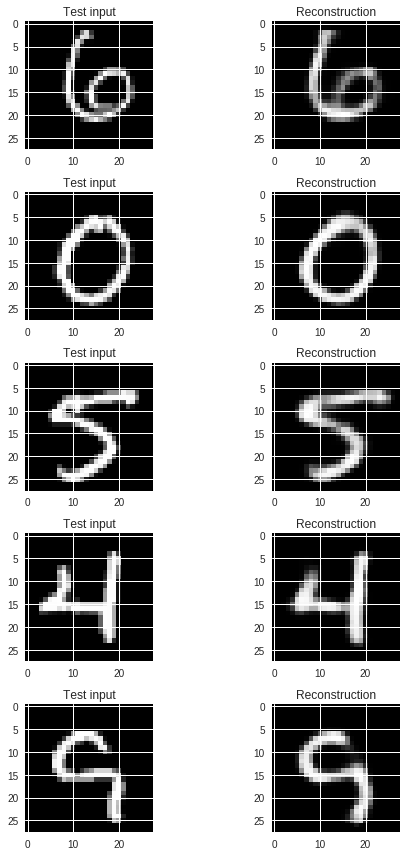

In [13]:
x_sample, _ = mnist.test.next_batch(100)
x_reconstruct = vae.reconstruct(x_sample)

fig = plt.figure(figsize=(8,12))
for i in range(5):
    ax1 = fig.add_subplot(5,2,2*i+1)
    ax1.set_title("Test input")
    ax1.imshow(x_sample[i].reshape(28,28), cmap='gray')
    
    ax2 = fig.add_subplot(5,2,2*i+2)
    ax2.set_title("Reconstruction")
    ax2.imshow(x_reconstruct[i].reshape(28,28), cmap='gray')
    
plt.tight_layout() 

# Generating new data

shape z:  (100, 20)


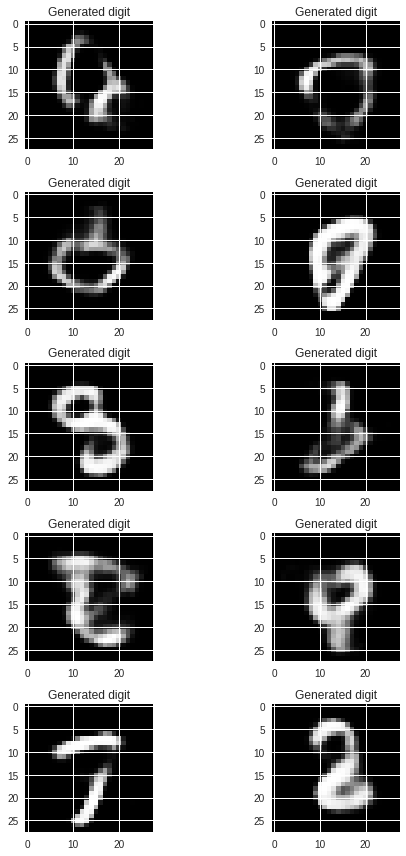

In [14]:
new_data = vae.generate_data()

fig = plt.figure(figsize=(8,12))

for i in range(10):
    ax = fig.add_subplot(5,2,i+1)
    ax.imshow(new_data[i].reshape(28,28), cmap='gray')
    ax.set_title("Generated digit")

plt.tight_layout()